# MOVIES INNIT MATE

In [410]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import os
import xgboost as xgb

# IMPORT DATASETS

Just checking if feed_into_pipeline_data.csv is the same as feed_into_pipeline_data_withLang.csv but with Language and other features

In [411]:
df = pd.read_csv('/Users/zachwayne/Downloads/Australia.csv')
withTags = pd.read_csv(os.path.relpath('/Users/zachwayne/Dropbox (MIT)/Netflix - Seize the Data/feed_into_pipeline_data_withTags.csv'))
summaries = pd.read_csv(os.path.relpath('/Users/zachwayne/Dropbox (MIT)/Netflix - Seize the Data/GlobalOriginalsWithSummary.csv'))[['combined_title', 'summary']]
people_rankings = pd.read_csv(os.path.relpath('/Users/zachwayne/Dropbox (MIT)/Netflix - Seize the Data/showsWithPrinicpalRankings.csv'))[['combined_title', 'director_rank', 'writer_rank', 'actor_rank']]
df = df[['tconst', 'cumulative_weeks_in_top_10']]
df = df.merge(withTags, on='tconst', how='left')

df['release_date'] = pd.to_datetime(df['release_date'])
df = df[df['release_date'] >= '6/1/2021']
# merge all 3 datasets
df = df.merge(summaries, on='combined_title')
df = df.merge(people_rankings, on='combined_title')
df.drop_duplicates(inplace=True)

df['is_top10'] = df['cumulative_weeks_in_top_10'].apply(lambda x: 1 if x > 0 else 0)
del df['cumulative_weeks_in_top_10']

# split into tv_shows only and sort by combined_title
movies = df[df['is_tv_show']==False]

# check if ordering before and after sorting by combined_title is the same
# tv_shows.sort_values(by='combined_title', inplace=True)
movies.reset_index(drop=True, inplace=True)
# tv_shows.head()

## Movies with <u>Rankings<u>

In [412]:
movies.head()

,tconst,combined_title,release_year,release_date,is_top10,lower_title,season,is_tv_show,averageRating,numVotes,...,nudity,violence,profanity,alcohol,frightening,language,summary,director_rank,writer_rank,actor_rank
0,tt13782052,1000 Miles from Christmas,2021.0,2021-12-24,0,1000 miles from christmas,NaN,False,5.8,1552.0,...,Mild,None,None,Mild,None,Spanish,"A Christmas tale, a romantic comedy and the st...",13557.5,29730.5,31277.83333
1,tt6275154,11M: Terror in Madrid,2022.0,2022-02-23,0,11m terror in madrid,NaN,False,6.9,1940.0,...,None,None,None,None,None,English,The story of the worst terrorist attack in Eur...,50497.0,NaN,NaN
2,tt16379224,137 Shots,2021.0,2021-12-15,0,137 shots,NaN,False,6.4,963.0,...,None,None,None,None,None,English,"In this documentary, law enforcement faces scr...",101870.5,NaN,487505.00000
3,tt3975918,13: The Musical,2022.0,2022-08-12,0,13 the musical,NaN,False,5.2,663.0,...,None,None,None,None,None,English,"After his parents' divorce, Evan Goldman moves...",567.0,30261.5,6840.00000
4,tt14079374,14 Peaks: Nothing Is Impossible,2021.0,2021-11-29,0,14 peaks nothing is impossible,NaN,False,7.7,25783.0,...,None,None,Mild,Mild,Mild,English,Fearless Nepali mountaineer Nirmal Purja embar...,24462.5,40838.5,316757.25000


In [413]:
drop_cols = ['combined_title', 'release_date', 'lower_title', 'season', 'is_tv_show', 'tconst']

In [414]:
# train test split with stratified sampling
from sklearn.model_selection import train_test_split

# split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(movies.drop(drop_cols + ['is_top10'], axis=1), movies['is_top10'], test_size=0.2, random_state=42, stratify=movies['is_top10'])

# # split into training and validation sets
# tvshows_X_train, tvshows_X_val, tvshows_y_train, tvshows_y_val = train_test_split(tvshows_X_train, tvshows_y_train, test_size=0.2, random_state=42, stratify=tvshows_y_train)

# XGBOOST

In [415]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import Normalizer

In [416]:
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
from nltk.stem import SnowballStemmer
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]
        
class StemTokenizer(object):
    def __init__(self):
        self.stemmer = SnowballStemmer('english')
    def __call__(self, articles):
        return [self.stemmer.stem(t) for t in word_tokenize(articles)]


tf_vectorizer = CountVectorizer(tokenizer=LemmaTokenizer(),
                       strip_accents = 'unicode',
                       stop_words = 'english',
                       lowercase = True)



In [417]:
from sklearn.feature_extraction import text

custom_stop_words = []
# add lemmatized stop words to stop_words list

for i in text.ENGLISH_STOP_WORDS:
    custom_stop_words.append(SnowballStemmer('english').stem(i))

In [418]:
new_stop_words = text.ENGLISH_STOP_WORDS.union(custom_stop_words)

In [419]:
def get_feature_names(estimator, numeric_features=['release_year', 'titleType', 'genres', 'summary', 'nudity', 'violence', 'profanity', 'alcohol', 'frightening', 'language', 'director_rank', 'actor_rank', 'writer_rank']):
    """Get feature names from a pipeline or column transformer."""
    feature_names = []
    for transformer in estimator.transformers_:
        try:
            if transformer[0] == 'rankings_pipeline':
                feature_names.append(['director_rank', 'actor_rank', 'writer_rank'])
            elif type(transformer[1]) == CountVectorizer:
                feature_names.append(transformer[2] + "_" + transformer[1].get_feature_names_out())
            else:
                feature_names.append(transformer[1].get_feature_names_out())
        except:
            pass
    feature_names = np.concatenate(feature_names)
    unchanged_features = [feature for feature in estimator.feature_names_in_ if feature not in numeric_features]
    feature_names = np.concatenate([feature_names, unchanged_features])
    return feature_names

## XGB with BOW, No Reviews or Votes

In [420]:
rankings_pipeline = Pipeline([
    #('imputer', SimpleImputer(strategy='mean')),
    #('imputer', IterativeImputer()),
    ('missingimputer', KNNImputer()),
    ('logger', FunctionTransformer(np.log1p))
])

xgb_transformer = ColumnTransformer(
    [
        ("onehot_titleType",OneHotEncoder(handle_unknown='ignore'), ['titleType']),                 # one-hot encode titleType
        #("onehot_release_year",OneHotEncoder(handle_unknown='ignore'), ['release_year']),           # discrete release year

        ("bagofwords", CountVectorizer(stop_words='english'), 'summary'),              # One hot encoding
        #("tfidf", TfidfVectorizer(tokenizer=LemmaTokenizer(), stop_words='english'), 'summary'),                  # TF-IDF
        ("genres_count", CountVectorizer(min_df=0.01), 'genres'),
        ("rankings_pipeline", rankings_pipeline, ['director_rank', 'actor_rank', 'writer_rank']),   # log transform rankings
        ("onehot_v",OneHotEncoder(handle_unknown='ignore'), ['violence']),                          # one-hot encode violence
        ("onehot_n",OneHotEncoder(handle_unknown='ignore'), ['nudity']),                            # one-hot encode nudity
        ("onehot_p",OneHotEncoder(handle_unknown='ignore'), ['profanity']),                         # one-hot encode profanity
        ("onehot_a",OneHotEncoder(handle_unknown='ignore'), ['alcohol']),                           # one-hot encode alcohol
        ("onehot_f",OneHotEncoder(handle_unknown='ignore'), ['frightening']),                       # one-hot encode frightening
        ("onehot_l",OneHotEncoder(min_frequency=0.01, handle_unknown='infrequent_if_exist'), ['language']),        # one-hot encode language
    ],
    remainder='passthrough')
# Recreate pipeline using XGBoost
xgb_pipe = Pipeline(
    steps=[
        ('xgb_transformer', xgb_transformer),
        #('normalizer', sklearn.preprocessing.Normalizer()),
        ('xgb', XGBClassifier())
    ]
)

xgb_gs_bow_drop = GridSearchCV(
    xgb_pipe,
    param_grid={
        'xgb__max_depth': [3,4,5],
        'xgb__learning_rate': [0.03, 0.05],
        'xgb__n_estimators': [100],
        'xgb__subsample': [0.8, 0.85, 0.9],
        'xgb_transformer__bagofwords__min_df': [0.01, 0.015, 0.02],
        'xgb_transformer__rankings_pipeline__missingimputer__n_neighbors': [5, 10, 15],
    },
    scoring={"AUC": "roc_auc", "F1": "f1", "Accuracy": "accuracy"},
    refit="AUC",
    cv=5,
    verbose=0,
    n_jobs=-1,
)
# fit xgb_gs_bow to training set
xgb_gs_bow_drop.fit(X_train.drop(columns=['averageRating', 'numVotes']), y_train)
xgb_gs_bow_drop.best_params_

{'xgb__learning_rate': 0.05,
 'xgb__max_depth': 3,
 'xgb__n_estimators': 100,
 'xgb__subsample': 0.9,
 'xgb_transformer__bagofwords__min_df': 0.02,
 'xgb_transformer__rankings_pipeline__missingimputer__n_neighbors': 15}

In [421]:
def get_results_model(model, X_test=X_test, y_test=y_test, name=""):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:,1]
    print(f"{name} AUC: %0.5f" % roc_auc_score(y_test, y_pred_proba))
    print(f"{name} F1: %0.5f" % f1_score(y_test, y_pred))
    print(f"{name} Accuracy: %0.5f" % accuracy_score(y_test, y_pred))
    return y_pred, y_pred_proba

def get_results_preds(y_labels, y_preds_proba, y_preds,  name=""):

    print(f"{name} AUC: %0.5f" % roc_auc_score(y_labels, y_preds_proba))
    print(f"{name} F1: %0.5f" % f1_score(y_labels, y_preds))
    print(f"{name} Accuracy: %0.5f" % accuracy_score(y_labels, y_preds))

In [422]:
# save best xgb_gs_bow model as a variable
best_xgb_gs_bow_drop = xgb_gs_bow_drop.best_estimator_

# output auc, f1-score, and accuracy on training set
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score

# output best score from xgb_gs_bow
print("XGBoost Bag of Words, Best score: %0.5f" % xgb_gs_bow_drop.best_score_)

y_pred, y_pred_proba = get_results_model(best_xgb_gs_bow_drop, X_test.drop(columns=['averageRating', 'numVotes']))

XGBoost Bag of Words, Best score: 0.89153
 AUC: 0.86769
 F1: 0.51613
 Accuracy: 0.84043


In [423]:
xgb_gs_bow_drop_feature_names = get_feature_names(best_xgb_gs_bow_drop['xgb_transformer'], ['titleType', 'genres', 'summary', 'nudity', 'violence', 'profanity', 'alcohol', 'frightening', 'language', 'director_rank', 'actor_rank', 'writer_rank'])

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


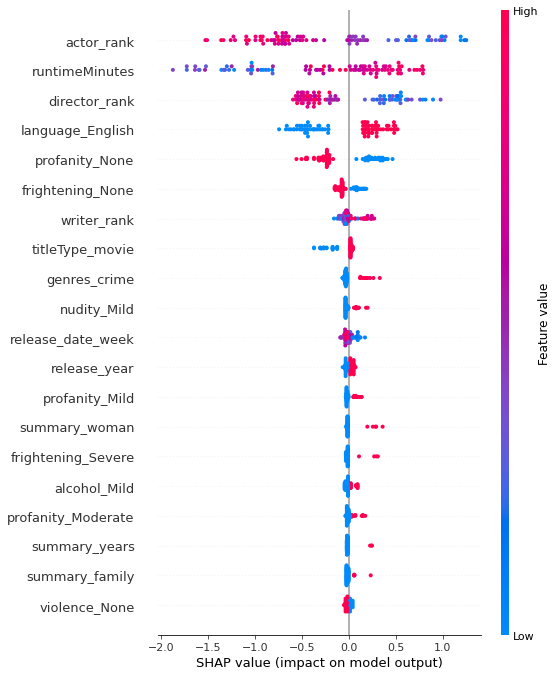

In [424]:
# make shap values
transformed_test = best_xgb_gs_bow_drop['xgb_transformer'].transform(X_test.drop(columns=['averageRating', 'numVotes']))
explainer = shap.TreeExplainer(best_xgb_gs_bow_drop['xgb'])
shap_values = explainer.shap_values(xgb.DMatrix(transformed_test, y_test))

# plot shap values
shap.summary_plot(shap_values, pd.DataFrame(transformed_test.todense()), feature_names=xgb_gs_bow_drop_feature_names)